In [1]:
import pandas as pd
import json 
import os 
import sys
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

path = '../data/llama2_7b'

In [2]:
def get_results(path): 
    res = []
    with open(os.path.join(path)) as f:
        for line in f:
            res.append(json.loads(line))

    monitor_losses = []
    gcg_losses = []
    early_stop = []
    for r in res:
        monitor_losses.append(r['monitor_losses'])
        gcg_losses.append(r['gcg_losses'])
        early_stop.append(np.any(r['early_stopping']))

    monitor_losses = np.array(monitor_losses)
    gcg_losses = np.array(gcg_losses)
    early_stop = np.array(early_stop)
    return monitor_losses, gcg_losses, early_stop

monitor_losses, gcg_losses, early_stop = get_results(os.path.join(path, 'gcg_run_llama_guard.json'))
hb_alpaca_monitor_losses, hb_alpaca_gcg_losses, hb_alpaca_early_stop = get_results(os.path.join(path, 'gcg_run_harmbench_alpaca.json'))
hb_alpaca_8_monitor_losses, hb_alpaca_8_gcg_losses, hb_alpaca_8_early_stop = get_results(os.path.join(path, 'gcg_run_harmbench_alpaca_8.json'))
hb_alpaca_16_monitor_losses, hb_alpaca_16_gcg_losses, hb_alpaca_16_early_stop = get_results(os.path.join(path, 'gcg_run_harmbench_alpaca_16.json'))
jb_monitor_losses, jb_gcg_losses, jb_early_stop = get_results(os.path.join(path, 'gcg_run_jb_.json'))
generated_monitor_losses, generated_gcg_losses, generated_early_stop = get_results(os.path.join(path, 'gcg_run_generated_.json'))
finetuned_monitor_losses_linear, finetuned_gcg_losses_linear, finetuned_early_stop_linear = get_results(os.path.join(path, 'gcg_run_llamaguard_finetuned_linear_.json'))
# monitor_losses_200, gcg_losses_200, early_stop_200 = get_results(os.path.join(path, 'gcg_run_llama_guard_200.js

In [3]:
monitor_losses_200, gcg_losses_200, early_stop_200 = get_results(os.path.join(path, 'gcg_run_llamaguard_200_.json'))
monitor_losses_linear, gcg_losses_linear, early_stop_linear = get_results(os.path.join(path, 'gcg_run_llamaguard_linear_.json'))
jb_200_monitor_losses, jb_200_gcg_losses, jb_200_early_stop = get_results(os.path.join(path, 'gcg_run_jb_200_.json'))
jb_linear_monitor_losses, jb_linear_gcg_losses, jb_linear_early_stop = get_results(os.path.join(path, 'gcg_run_jb_linear_.json'))

In [4]:
# no monitor
only_gcg_monitor_losses, only_gcg_gcg_losses, only_gcg_early_stop = get_results(os.path.join(path, 'gcg_run_.json'))
only_gcg_linear_monitor_losses, only_gcg_linear_gcg_losses, only_gcg_linear_early_stop = get_results(os.path.join(path, 'gcg_run_linear_.json'))

### Linear

In [6]:
sns.set()

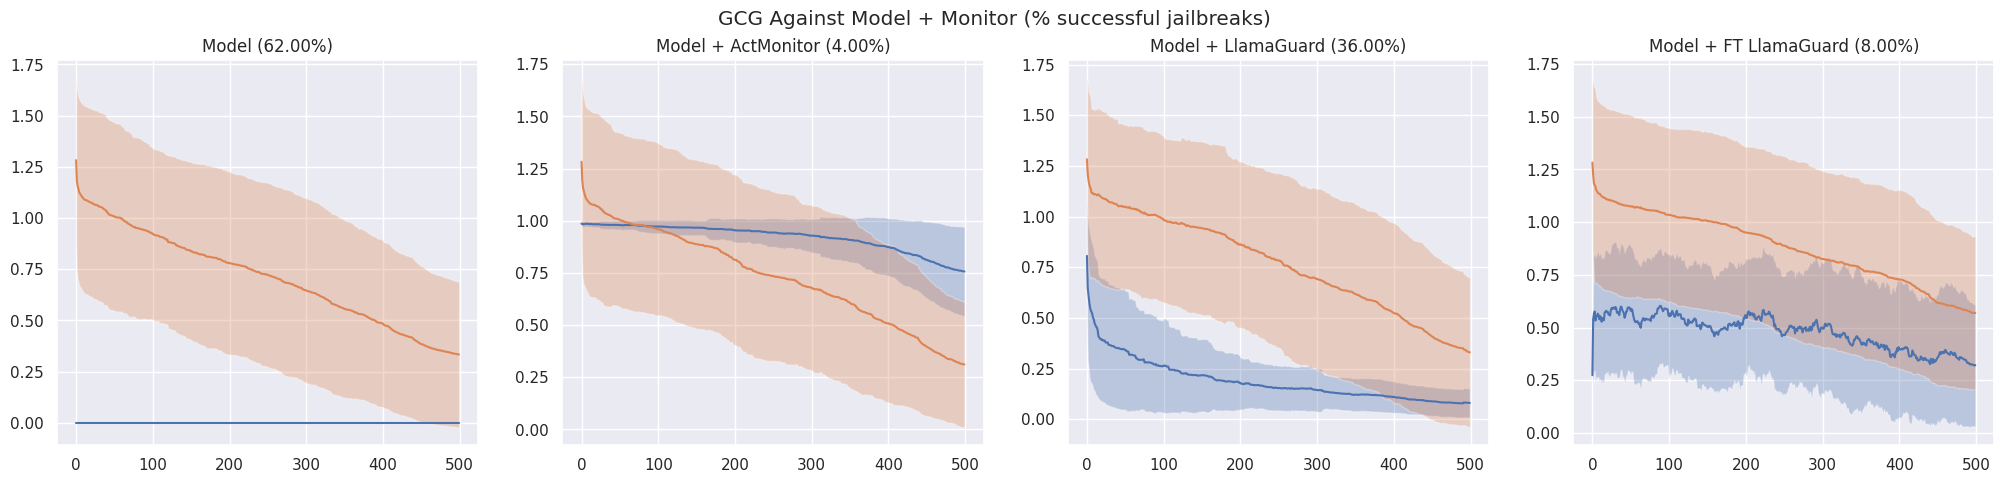

In [18]:
fig, axs = plt.subplots(1, 4, figsize=(25, 5))
# plot no monitor, jb, llama guard and finetuned llamaguard
axs[0].plot(only_gcg_linear_monitor_losses.mean(axis=0), label='Monitor Loss')
axs[0].plot(only_gcg_linear_gcg_losses.mean(axis=0), label='GCG Loss')
axs[0].fill_between(np.arange(only_gcg_linear_monitor_losses.shape[1]), only_gcg_linear_monitor_losses.mean(axis=0) - only_gcg_linear_monitor_losses.std(axis=0), only_gcg_linear_monitor_losses.mean(axis=0) + only_gcg_linear_monitor_losses.std(axis=0), alpha=0.3)
axs[0].fill_between(np.arange(only_gcg_linear_gcg_losses.shape[1]), only_gcg_linear_gcg_losses.mean(axis=0) - only_gcg_linear_gcg_losses.std(axis=0), only_gcg_linear_gcg_losses.mean(axis=0) + only_gcg_linear_gcg_losses.std(axis=0), alpha=0.3)
axs[0].set_title(f'Model ({only_gcg_early_stop.mean()*100:.2f}%)')

axs[1].plot(jb_linear_monitor_losses.mean(axis=0), label='Monitor Loss')
axs[1].plot(jb_linear_gcg_losses.mean(axis=0), label='GCG Loss')
axs[1].fill_between(np.arange(jb_linear_monitor_losses.shape[1]), jb_linear_monitor_losses.mean(axis=0) - jb_linear_monitor_losses.std(axis=0), jb_linear_monitor_losses.mean(axis=0) + jb_linear_monitor_losses.std(axis=0), alpha=0.3)
axs[1].fill_between(np.arange(jb_linear_gcg_losses.shape[1]), jb_linear_gcg_losses.mean(axis=0) - jb_linear_gcg_losses.std(axis=0), jb_linear_gcg_losses.mean(axis=0) + jb_linear_gcg_losses.std(axis=0), alpha=0.3)
axs[1].set_title(f'Model + ActMonitor ({jb_linear_early_stop.mean()*100:.2f}%)')

axs[2].plot(monitor_losses.mean(axis=0), label='GCG Loss')
axs[2].plot(gcg_losses.mean(axis=0), label='Monitor Loss')
axs[2].fill_between(np.arange(monitor_losses.shape[1]), monitor_losses.mean(axis=0) - monitor_losses.std(axis=0), monitor_losses.mean(axis=0) + monitor_losses.std(axis=0), alpha=0.3)
axs[2].fill_between(np.arange(gcg_losses.shape[1]), gcg_losses.mean(axis=0) - gcg_losses.std(axis=0), gcg_losses.mean(axis=0) + gcg_losses.std(axis=0), alpha=0.3)
axs[2].set_title(f'Model + LlamaGuard ({early_stop_linear.mean()*100:.2f}%)')

axs[3].plot(finetuned_monitor_losses_linear.mean(axis=0), label='Monitor Loss')
axs[3].plot(finetuned_gcg_losses_linear.mean(axis=0), label='GCG Loss')
axs[3].fill_between(np.arange(finetuned_monitor_losses_linear.shape[1]), finetuned_monitor_losses_linear.mean(axis=0) - finetuned_monitor_losses_linear.std(axis=0), finetuned_monitor_losses_linear.mean(axis=0) + finetuned_monitor_losses_linear.std(axis=0), alpha=0.3)
axs[3].fill_between(np.arange(finetuned_gcg_losses_linear.shape[1]), finetuned_gcg_losses_linear.mean(axis=0) - finetuned_gcg_losses_linear.std(axis=0), finetuned_gcg_losses_linear.mean(axis=0) + finetuned_gcg_losses_linear.std(axis=0), alpha=0.3)
axs[3].set_title(f'Model + FT LlamaGuard ({finetuned_early_stop_linear.mean()*100:.2f}%)')

plt.suptitle('GCG Against Model + Monitor (% successful jailbreaks)')
plt.show()

### 200 decay

### standard 300 decay

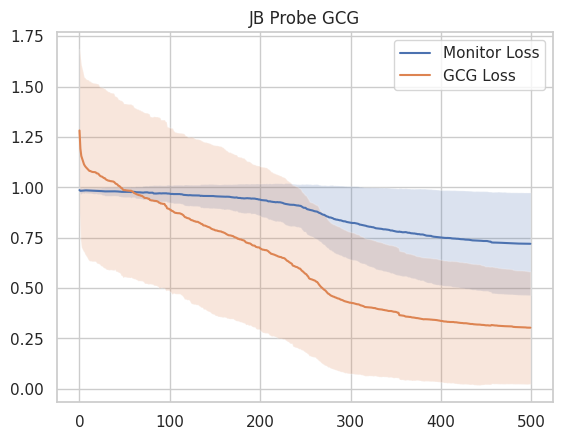

In [7]:
sns.set(style='whitegrid')
plt.plot(jb_monitor_losses.mean(axis=0), label='Monitor Loss')
plt.plot(jb_gcg_losses.mean(axis=0), label='GCG Loss')
plt.fill_between(range(500), jb_monitor_losses.mean(axis=0) - jb_monitor_losses.std(axis=0), jb_monitor_losses.mean(axis=0) + jb_monitor_losses.std(axis=0), alpha=0.2)
plt.fill_between(range(500), jb_gcg_losses.mean(axis=0) - jb_gcg_losses.std(axis=0), jb_gcg_losses.mean(axis=0) + jb_gcg_losses.std(axis=0), alpha=0.2)
plt.legend()
plt.title('JB Probe GCG')
plt.show()

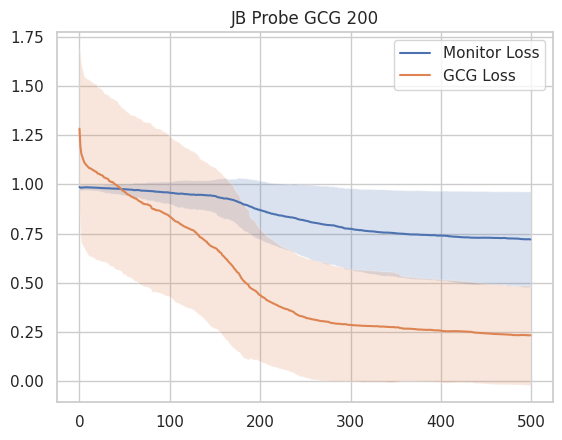

In [8]:
sns.set(style='whitegrid')
plt.plot(jb_200_monitor_losses.mean(axis=0), label='Monitor Loss')
plt.plot(jb_200_gcg_losses.mean(axis=0), label='GCG Loss')
plt.fill_between(range(500), jb_200_monitor_losses.mean(axis=0) - jb_200_monitor_losses.std(axis=0), jb_200_monitor_losses.mean(axis=0) + jb_200_monitor_losses.std(axis=0), alpha=0.2)
plt.fill_between(range(500), jb_200_gcg_losses.mean(axis=0) - jb_200_gcg_losses.std(axis=0), jb_200_gcg_losses.mean(axis=0) + jb_200_gcg_losses.std(axis=0), alpha=0.2)
plt.legend()
plt.title('JB Probe GCG 200')
plt.show()

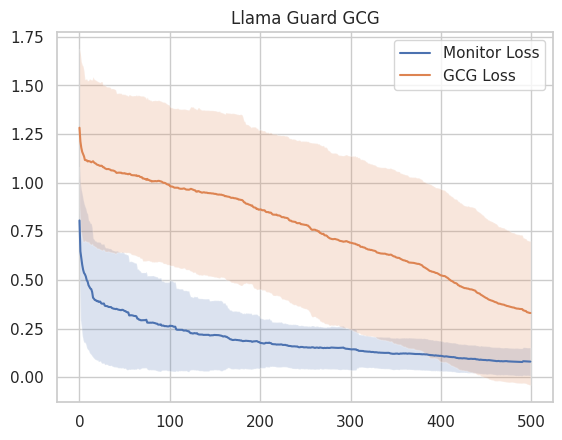

In [11]:
sns.set(style='whitegrid')
plt.plot(monitor_losses.mean(axis=0), label='Monitor Loss')
plt.plot(gcg_losses.mean(axis=0), label='GCG Loss')
plt.fill_between(range(500), monitor_losses.mean(axis=0) - monitor_losses.std(axis=0), monitor_losses.mean(axis=0) + monitor_losses.std(axis=0), alpha=0.2)
plt.fill_between(range(500), gcg_losses.mean(axis=0) - gcg_losses.std(axis=0), gcg_losses.mean(axis=0) + gcg_losses.std(axis=0), alpha=0.2)
plt.legend()
plt.title('Llama Guard GCG')
plt.show()

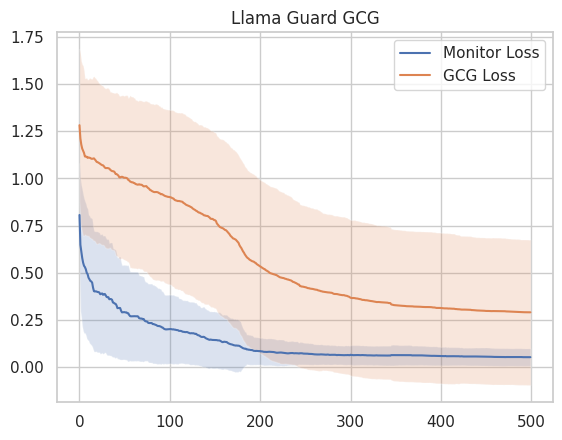

In [12]:
sns.set(style='whitegrid')
plt.plot(monitor_losses_200.mean(axis=0), label='Monitor Loss')
plt.plot(gcg_losses_200.mean(axis=0), label='GCG Loss')
plt.fill_between(range(500), monitor_losses_200.mean(axis=0) - monitor_losses_200.std(axis=0), monitor_losses_200.mean(axis=0) + monitor_losses_200.std(axis=0), alpha=0.2)
plt.fill_between(range(500), gcg_losses_200.mean(axis=0) - gcg_losses_200.std(axis=0), gcg_losses_200.mean(axis=0) + gcg_losses_200.std(axis=0), alpha=0.2)
plt.legend()
plt.title('Llama Guard GCG')
plt.show()

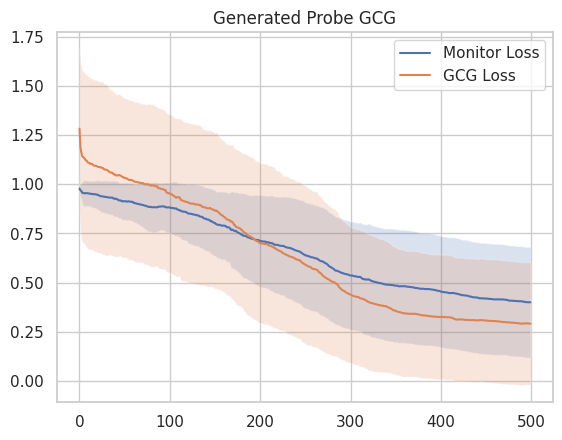

In [7]:
sns.set(style='whitegrid')
plt.plot(generated_monitor_losses.mean(axis=0), label='Monitor Loss')
plt.plot(generated_gcg_losses.mean(axis=0), label='GCG Loss')
plt.fill_between(range(500), generated_monitor_losses.mean(axis=0) - generated_monitor_losses.std(axis=0), generated_monitor_losses.mean(axis=0) + generated_monitor_losses.std(axis=0), alpha=0.2)
plt.fill_between(range(500), generated_gcg_losses.mean(axis=0) - generated_gcg_losses.std(axis=0), generated_gcg_losses.mean(axis=0) + generated_gcg_losses.std(axis=0), alpha=0.2)
plt.legend()
plt.title('Generated Probe GCG')
plt.show()

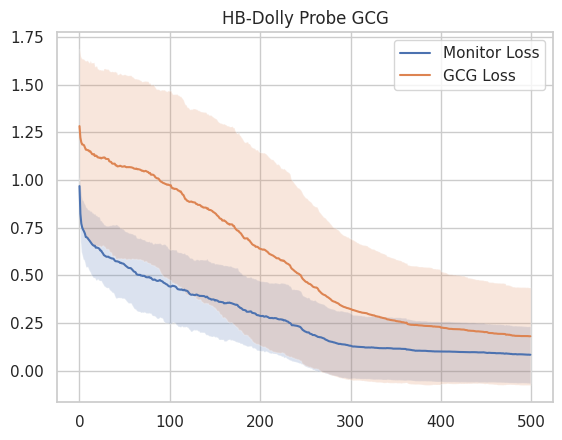

In [9]:
sns.set(style='whitegrid')
plt.plot(hb_dolly_monitor_losses.mean(axis=0), label='Monitor Loss')
plt.plot(hb_dolly_gcg_losses.mean(axis=0), label='GCG Loss')
plt.fill_between(range(500), hb_dolly_monitor_losses.mean(axis=0) - hb_dolly_monitor_losses.std(axis=0), hb_dolly_monitor_losses.mean(axis=0) + hb_dolly_monitor_losses.std(axis=0), alpha=0.2)
plt.fill_between(range(500), hb_dolly_gcg_losses.mean(axis=0) - hb_dolly_gcg_losses.std(axis=0), hb_dolly_gcg_losses.mean(axis=0) + hb_dolly_gcg_losses.std(axis=0), alpha=0.2)
plt.legend()
plt.title('HB-Dolly Probe GCG')
plt.show()

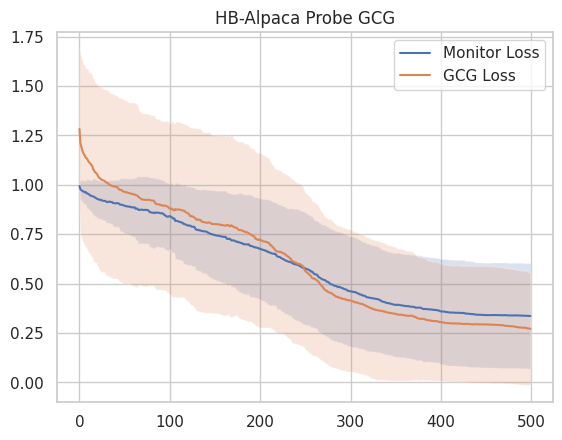

In [11]:
sns.set(style='whitegrid')
plt.plot(hb_alpaca_monitor_losses.mean(axis=0), label='Monitor Loss')
plt.plot(hb_alpaca_gcg_losses.mean(axis=0), label='GCG Loss')
plt.fill_between(range(500), hb_alpaca_monitor_losses.mean(axis=0) - hb_alpaca_monitor_losses.std(axis=0), hb_alpaca_monitor_losses.mean(axis=0) + hb_alpaca_monitor_losses.std(axis=0), alpha=0.2)
plt.fill_between(range(500), hb_alpaca_gcg_losses.mean(axis=0) - hb_alpaca_gcg_losses.std(axis=0), hb_alpaca_gcg_losses.mean(axis=0) + hb_alpaca_gcg_losses.std(axis=0), alpha=0.2)
plt.legend()
plt.title('HB-Alpaca Probe GCG')
plt.show()